First, import some useful packages and set everything up (e.g., inline plotting)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from math import *

Let's start with defining the solution for least squares regression in closed form

In [2]:
# compute parameters of the linear regression of phi(x)->y
# Inputs:
#   x, y: the training data and labels, respectively
#   transform: function mapping x to features phi(x)
# Output:
# w : parameters of the trained model
def lr_closed_form(x,y,transform):
    return np.dot(np.linalg.pinv(transform(x)),y)

The function below (that perhaps could be simplified) defines a generalized polynomial feature expansion, specified as a list of degrees.

In [3]:
def polyFv(x,degs,mu=None,sigma=None):
    # Map m-dim input vector x to [x_1^d_1, x_2^d_1,...,x_m^d_1,x_1^d_2,...,x_m^d_k]
    # where degs is the list (d_1,...,d_k)
    # if d_j=0, only include a single copy of 1 (and not m copies)
    #
    # If mu and sigma are passed, this function will normalize each feature j, subtracting mu[j] and dividing by sigma[j].
    # If mu and sigma are not passed: they will be calculated, and returned as additional outputs, so the function will
    #   return a tuple (X,mu,sigma); if you want to just compute the feature map, but do not pass mu/sigma, then use
    #   polyFv(x)[0]
    
    nd=len(degs) 
    
    if len(x.shape)==1: 
        x=x[:,np.newaxis] # force a "data matrix" form, even if there's only a single feature

    N,m=x.shape
    
    # calculate the dimension of the transformed feature vector phi(x)
    if 0 in degs:
        M=(len(degs)-1)*m+1
    else:
        M=len(degs)*m
        
    X=np.empty([N,M])
    if 0 in degs:
        X[:,0]=1
        j=1
    else:
        j=0 # index to keep track of where to write the next chunk of features
        
    for d in range(len(degs)):
        if degs[d] != 0:
            X[:,j:j+m]=x**degs[d]
            j=j+m
            
    # normalize
    if mu is None:
        mu = X.mean(0) 
        sigma = X.std(0)
        sigma[0]=1 
        sigma[sigma<0.0001]=1 
        return_normalizer = True
    else:
        return_normalizer = False
        
    X=(X-mu)/sigma #columnwise normalization
    
    if 0 in degs:
        X[:,0]=1

    if return_normalizer:
        return X, mu, sigma
    else:
        return X

# Toy experiment with 1D regression

Before we work on a real dataset with a multi-dimensional input space, let's explore regression in 1D inputs, which is easy to visualize. We will do this with a <i>synthetic</i> data domain, where we simply generate the data from a noisy model.
Note that in this case, contrary to the real world scenario, we can ask how well the regression method recovers the true model; in the real world case this is of course not a meaningful question because we will never know the true model.

In [4]:
# generate range of 1d xs, from -2 to 2, with a given step
def genXrange(step):
    xt=np.arange(-2,2,step)
    xtick=np.empty([xt.shape[0],1])
    xtick[:,0]=xt
    return xtick

In [5]:
# generate a dataset {(x,y)} where y = f(x) + noise
# n: # of examples
# sigma: std. deviation of the noise in y
# f: the function accounting for the deterministic component in y
def genD(n,sigma,f):
    
    # first get xs -- jitter them around a bit with uniform noise
    xraw=np.linspace(-2,2,n)
    xnoise=np.random.uniform(-.1,.1,xraw.shape)
    x=np.empty([xraw.shape[0],1])
    x[:,0]=xraw+xnoise
    
    # now generate ys
    y=f(x)
    ynoise=np.random.normal(0,sigma,y.shape)
    y=np.squeeze(y+ynoise)
    
    return x,y

In [6]:
# the function we will be using as the source of our x->y data. You can see how modifying f,
# for example making it more or less smooth, affects the experiments below.
def f(x):
    return np.sin(x*1.7)+.1*x**2+3

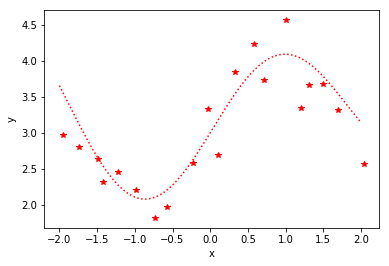

In [7]:
# let's test it out: generate a dataset and plot it
x, y = genD(20,.3,f)

plt.plot(x,y,'r*')
plt.xlabel('x')
plt.ylabel('y');

# and also plot the function over a dense 1D "grid" of x values
xtick=genXrange(.01)
plt.plot(xtick,f(xtick),'r:')

Now we are going to build a simple toolkit for 1D regression. It will be limited to solving least squares in closed form, but powerful enough to allow non-linear features.

In [8]:
# define some feature maps
# we could define a separate function for each set of features, but using lambda expressions
# seems more convenient
_, muL, sigmaL = polyFv(x,(0,1))
_, muQ, sigmaQ = polyFv(x,(0,1,2))
_, mu3, sigma3 = polyFv(x,range(0,4))
_, mu7, sigma7 = polyFv(x,range(0,8))
_, mu15, sigma15 = polyFv(x,range(0,21))

mapLinear = lambda x: polyFv(x,(0,1),muL,sigmaL)
map2 = lambda x: polyFv(x,(0,1,2),muQ,sigmaQ)
map3 = lambda x: polyFv(x,range(0,4),mu3,sigma3)
map7 = lambda x: polyFv(x,range(0,8),mu7,sigma7)
map15 = lambda x: polyFv(x,range(0,21),mu15,sigma15)

In [9]:
# a function to conveniently visualize the regression model, plotting it over a dense grid of inputs
# Input:
#   w : the regression model (parameter vector)
#   transform: the feature transform mapping x to phi(x)
#   style: line style
#   step: density of the grid on which the model is visualized
def plotLR(w,transform,style='k-',step=0.01):
    # sample inputs (xs) on a dense grid with given step
    xtick=genXrange(step)

    # predict y for each x using the model
    yhat=np.dot(transform(xtick),w)

    # draw the line (note: plot will interpolate the predictions, making it appear as a continuous line)
    plt.plot(xtick,yhat,style)

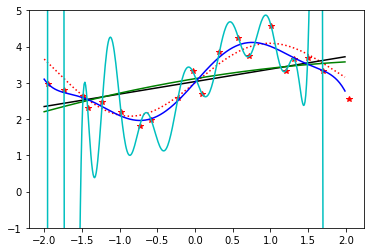

In [10]:
w1=lr_closed_form(x,y,mapLinear)
w2=lr_closed_form(x,y,map2)
w7=lr_closed_form(x,y,map7)
w15=lr_closed_form(x,y,map15)

plt.plot(x,y,'r*')
xtick=genXrange(.01)
plt.plot(xtick,f(xtick),'r:')

plotLR(w1,mapLinear,'k-')
plotLR(w2,map2,'g-')
plotLR(w7,map7,'b-')

plotLR(w15,map15,'c')
plt.ylim(-1,5);

Just as in the examples we saw in class, this shows that more complex models can fit the <i>training</i> data better. 
We can evaluate these models numerically, by computing training loss (avg. squared error) as well as the test loss (on the test set we will shortly generate). We will define an actual Python function that implements our (mathematical) loss function. 

Ignore the gradient related bits for now; we will need them later.

In [11]:
def lossSquared(X,y,w,getGrad=False):
    yhat = np.dot(X,w)
    err = np.squeeze(yhat)-y # prediction error values, for all the points in x
    loss = np.mean(err**2)
    if getGrad:
        grad = 2*np.mean(X*err.reshape(err.shape[0],1),axis=0)
        return loss, grad.reshape(w.shape)
    else:
        return loss

In [12]:
# make sure to use the same noise parameters and f as in generating the training set!
xTest, yTest = genD(100,.3,f)

In [13]:
Ms = (0,1,2,3,5,7,15,25)
polyModels = {}
errTrain = np.zeros((len(Ms)))

errTest = np.zeros((len(Ms)))

for m in range(len(Ms)):
    _,mu,sigma=polyFv(x,range(0,Ms[m]+1))
    transform = lambda x: polyFv(x,range(0,Ms[m]+1),mu,sigma)
    polyModels[m] = lr_closed_form(x,y,transform)
    errTrain[m] = lossSquared(transform(x),y,polyModels[m])
    errTest[m] = lossSquared(transform(xTest),yTest,polyModels[m])

In [14]:
print('\t\tTrain err\tTest err\n')
for m in range(len(Ms)):
    print('model %03d:\t%.04f\t\t%.04f'%(Ms[m],errTrain[m],errTest[m]))

		Train err	Test err

model 000:	0.5464		0.5949
model 001:	0.3755		0.4163
model 002:	0.3705		0.4407
model 003:	0.1117		0.1184
model 005:	0.0762		0.1496
model 007:	0.0668		0.1428
model 015:	0.0473		101.4936
model 025:	0.0000		196355306.8127


So, as expected, more complex models reduce training RMSE, but at some point along the complexity axis, the test RMSE starts increasing, due to overfitting (this is also graphically evident in the plot, of course).

It would be interesting to see how this table would change if we had more training data than 20 points...

# Real Dataset: Boston Housing

We are now ready for some more realistic experiments. Let's consider the Boston Housing data set, originally from the UCI data repository. It's packaged with the scikit-learn distribution available with Anaconda, so it's easy to load it. It's in a rather fancy format, containing in addition to the raw data a description explaining what the features are.

The task here is to predict median house prices (in circa 1980 dollars, so don't be shocked! :-) based on various measurements of the neighborhoods in Boston.

In [15]:
import sklearn
from sklearn.datasets import load_boston
boston=load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

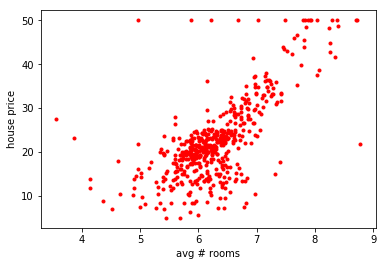

In [16]:
xhouse=boston.data
yhouse=boston.target
# visualize house price as a function of, say, "avg. number of rooms in a dwelling"
plt.plot(xhouse[:,5],yhouse,'r.')
plt.xlabel('avg # rooms')
plt.ylabel('house price');

We will first shuffle the data; to make sure everyone is working with the same partitions, we will fix the seed of the pseudorandom number generator.

In [17]:
np.random.seed(54321)
p = np.random.permutation(xhouse.shape[0])
xhouse=xhouse[p,:]
yhouse=yhouse[p]

We need to partition the data into train, val, and test. Let's put approximately 70% in train, 15% in val, and 15% in test. 

In [18]:
Ntrain=350
Nval=75
Ntest=xhouse.shape[0]-Ntrain-Nval

xtrain = xhouse[0:Ntrain,:]
ytrain = yhouse[0:Ntrain]
xval = xhouse[Ntrain:Ntrain+Nval,:]
yval = yhouse[Ntrain:Ntrain+Nval]
xtest = xhouse[Ntrain+Nval:,:]
ytest = yhouse[Ntrain+Nval:]

Instead of using the closed form solution, we will now try to learn the model using gradient descent.

Let's define a general-ish gradient descent routine. It will take as input the data (x,y), and the specifications of how to map the x to the feature space; how to run optimization; and how to evaluate loss (and its gradient).

## Problem 5

In [19]:
def GD(x,y,transform,optim,lfunc):
    X = transform(x)
    w = np.zeros((X.shape[1]))
    converged = False
    lr=optim['lr']
    loss=np.empty([optim['maxiter']]) # will keep track of training loss
    
    t = 0 # iteration count
    m1 = 50

    while not converged:
        loss[t],lgrad = lfunc(X,y,w,getGrad=True)
        # 1) computing the gradient-based update;
        w = w - lr * lgrad
        
        # 2) checking for convergence;
        if t >= optim['miniter']:
            if optim['mindelta'] >= loss[t-m1]/loss[t]:
                print('converged!')
                converged = True

        # 3) updating learning rate and doing anything else you want to do as part of the optimization routine
        # look at the keys of optim dictionary below for inspiration/hints
        freq = (t + 1) % optim['dropfreq']
        if freq == 0:
            lr *= optim['lrdrop']
        if t >= optim['maxiter']:
            print('did not converge!')
            break
        
        t=t+1
    
    loss=loss[:t]
    return w,loss

We will fill in some reasonable values for a few optimization-related parameters that you may want to use.

In [20]:
# Note: these parameters have been tuned for the best convergence in case of symmetric loss
optim={}
optim['maxiter']=50000     # stop after at most this many iterations
optim['lr']=.01            # (initial) learning rate
optim['miniter']=100       # minimal number of iterations
optim['mindelta']=1.0001   # tolerance for loss drop; stop if loss(t-m)/loss(t) < this value, for some m
optim['lrdrop']=.5         # when dropping learning rate, use this factor to reduce it
optim['dropfreq']=200      # how often do we drop the learning rate (every this many iterations)

You should be able to train a linear model with the code below; you can compare it to the closed form solution to make sure you get similar results.

converged!
[1216 iter] train RMSE 4.7378, val RMSE 5.5261


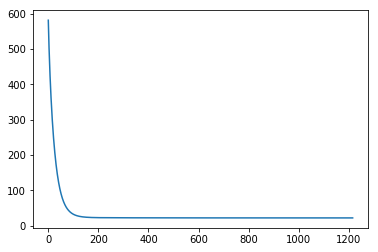

In [21]:
# define feature transform
_,mu,sigma=polyFv(xtrain,(0,1))
fmap=lambda x: polyFv(x,(0,1),mu,sigma)
# train model
w,loss = GD(xtrain,ytrain,fmap,optim,lossSquared)
# evaluate on train and val sets
lossTrain=lossSquared(fmap(xtrain),ytrain,w)
lossVal=lossSquared(fmap(xval),yval,w)
print('[%d iter] train RMSE %.4f, val RMSE %.4f'%(len(loss),sqrt(lossTrain),sqrt(lossVal)))
# plot the loss value over iterations, to observe the learning process
plt.plot(loss)

Now we can explore some more feature spaces...

In [22]:
fsets=((0,),(0,1),(0,1,2),(0,1,2,3), (0,1,2,3,4))  # try others!

models_symm={}
for f in fsets:
    models_symm[f]={}
    _,mu,sigma=polyFv(xtrain,f)
    fmap=lambda x: polyFv(x,f,mu,sigma)
    models_symm[f]['w'],models_symm[f]['loss'] = GD(xtrain,ytrain,fmap,optim,lossSquared)
    models_symm[f]['lossTrain']=lossSquared(fmap(xtrain),ytrain,models_symm[f]['w'])
    models_symm[f]['lossVal']=lossSquared(fmap(xval),yval,models_symm[f]['w'])

converged!
converged!
converged!
converged!
converged!


In [23]:
for f in fsets:
    print('Model %s: train RMSE %.4f, val RMSE %.4f' %(f,sqrt(models_symm[f]['lossTrain']),sqrt(models_symm[f]['lossVal'])))

Model (0,): train RMSE 9.0049, val RMSE 10.3318
Model (0, 1): train RMSE 4.7378, val RMSE 5.5261
Model (0, 1, 2): train RMSE 4.5513, val RMSE 5.5573
Model (0, 1, 2, 3): train RMSE 4.2185, val RMSE 5.4935
Model (0, 1, 2, 3, 4): train RMSE 3.9594, val RMSE 5.5329


The validation RMSE does not change much after the linear model, so I select the linear model because it is the simplest.

In [24]:
# Closed form solution for validation
fsets=((0,),(0,1),(0,1,2),(0,1,2,3), (0,1,2,3,4))  # try others!

models={}
for f in fsets:
    models[f]={}
    _,mu,sigma=polyFv(xtrain,f)
    fmap=lambda x: polyFv(x,f,mu,sigma)
    
    models[f]['w'] = lr_closed_form(xtrain,ytrain,fmap)
    models[f]['lossTrain']=lossSquared(fmap(xtrain),ytrain,models[f]['w'])
    models[f]['lossVal']=lossSquared(fmap(xval),yval,models[f]['w'])

print('Closed form solutions:')
for f in fsets:
    print('Model %s: train RMSE %.4f, val RMSE %.4f' %(f,sqrt(models[f]['lossTrain']),sqrt(models[f]['lossVal'])))

Closed form solutions:
Model (0,): train RMSE 9.0047, val RMSE 10.3283
Model (0, 1): train RMSE 4.6868, val RMSE 5.4508
Model (0, 1, 2): train RMSE 3.5330, val RMSE 5.5655
Model (0, 1, 2, 3): train RMSE 3.3201, val RMSE 5.8740
Model (0, 1, 2, 3, 4): train RMSE 3.2179, val RMSE 5.5183


Based on the exploration above, at this point you will have selected a model (i.e., feature space in which a linear model operates). Now let's see what changes when we move to an asymmetric loss.

In [25]:
def asymmLoss(X, y, w, alpha,getGrad=False):
    """
    Get the asymmetric loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    y : 1D array
        Observed function values
    w : 1D array
        d+1 length vector
    Returns
    -------
    loss : a scalar
        The loss calculated by equation in problem set 1
    """

    yhat = np.dot(X,w)
    err = np.squeeze(yhat)-y # prediction error values, for all the points in x
    err = np.array(err)
    weight = (err < 0) * alpha + (err >= 0)
    loss = np.mean((err**2) * weight)
    
    if getGrad:
        grad = 2*np.mean(X*err.reshape(err.shape[0],1)*weight.reshape(err.shape[0],1),axis=0)
        return loss, grad.reshape(w.shape)
    else:
        return loss

In [26]:
# for convenience, we will define this lambda expression so we could call it inside GD without passing alpha to GD (which does
# not expect it -- we sort of make the asymmetric loss backward compatible...)
def aloss(alpha):
    return lambda x,y,w,getGrad: asymmLoss(x,y,w,alpha,getGrad)

We can now train a model, say a linear one, using code very similar to what we did before (the only difference is in the use of
the asymmetric loss, both in calling GD and in evaluating the resulting model on the val set

In [27]:
# Note: these parameters have been tuned for the best convergence in case of asymmetric loss
optim={}
optim['maxiter']=50000     # stop after at most this many iterations
optim['lr']=.01            # (initial) learning rate
optim['miniter']=100       # minimal number of iterations
optim['mindelta']=1.0001   # tolerance for loss drop; stop if loss(t-m)/loss(t) < this value, for some m
optim['lrdrop']=.99         # when dropping learning rate, use this factor to reduce it
optim['dropfreq']=100      # how often do we drop the learning rate (every this many iterations)

In [28]:
alpha=0.05

_, mu, sigma = polyFv(xtrain, (0, 1))
fmap = lambda x: polyFv(x, (0,1), mu, sigma)
w, loss = GD(xtrain, ytrain, fmap, optim, aloss(alpha))
rmseTrain = lossSquared(fmap(xtrain), ytrain, w)
rmseVal = lossSquared(fmap(xval), yval, w)
alossVal = asymmLoss(fmap(xval), yval, w, alpha)
print('[%d iter] train RMSE %.4f, val RMSE %.4f, weighted %.4f'%(len(loss),sqrt(rmseTrain),sqrt(rmseVal),sqrt(alossVal)))

converged!
[8911 iter] train RMSE 6.2153, val RMSE 7.1138, weighted 1.8615


Now we can experiment, using the validation set to select the model class and set parameter values (similarly to what was done with symmetric loss).

When we are done, we can evaluate the best model we have found on the test set.

In [29]:
fsets=((0,),(0,1),(0,1,2),(0,1,2,3), (0,1,2,3,4), (0,1,2,3,4,5), (0,1,2,3,4,5,6,7,8), (0,1,2,3,4,5,6,7))  # try others!

models_asymm={}
for f in fsets:
    models_asymm[f]={}
    _,mu,sigma=polyFv(xtrain,f)
    fmap=lambda x: polyFv(x,f,mu,sigma)
    models_asymm[f]['w'],models_asymm[f]['loss'] = GD(xtrain,ytrain,fmap,optim,aloss(alpha))
    models_asymm[f]['lossTrain']=asymmLoss(fmap(xtrain),ytrain,models_asymm[f]['w'],alpha)
    models_asymm[f]['lossVal']=asymmLoss(fmap(xval),yval,models_asymm[f]['w'],alpha)

converged!
converged!
converged!
converged!
converged!
converged!
converged!
converged!


In [30]:
print('Results with asymmetric loss is:')
for f in fsets:
    print('Model %s: train RMSE %.4f, val RMSE %.4f' %(f,sqrt(models_asymm[f]['lossTrain']),sqrt(models_asymm[f]['lossVal'])))

Results with asymmetric loss is:
Model (0,): train RMSE 3.1846, val RMSE 3.4225
Model (0, 1): train RMSE 1.5535, val RMSE 1.8615
Model (0, 1, 2): train RMSE 1.4609, val RMSE 1.9722
Model (0, 1, 2, 3): train RMSE 1.3539, val RMSE 2.3513
Model (0, 1, 2, 3, 4): train RMSE 1.2857, val RMSE 2.8495
Model (0, 1, 2, 3, 4, 5): train RMSE 1.2606, val RMSE 3.2111
Model (0, 1, 2, 3, 4, 5, 6, 7, 8): train RMSE 1.2541, val RMSE 3.5255
Model (0, 1, 2, 3, 4, 5, 6, 7): train RMSE 1.2558, val RMSE 3.4988


From the tests, clearly, the linear model has the low validation RMSE, and it is the simplest, so I choose it.

All right, we now have a model selected under regular squared loss, and a model selected under asymmetric loss. We can evaluate each of these two models on the test set, with its "native" loss and with the other loss (so you will get a total of four values: "symmetric model with symmetric loss", "symmetric model with asymmetric loss" etc.)

In [31]:
# Note: I am calculating the optimal parameters based on both train and validation data
xtrain = xhouse[0:Ntrain+Nval,:]
ytrain = yhouse[0:Ntrain+Nval,]
best_f = (0,1)
_,mu,sigma=polyFv(xtrain,(0,1))
fmap=lambda x: polyFv(x,(0,1),mu,sigma)

In [32]:
# Note: these parameters have been tuned for the best convergence in case of symmetric loss
optim={}
optim['maxiter']=50000     # stop after at most this many iterations
optim['lr']=.01            # (initial) learning rate
optim['miniter']=100       # minimal number of iterations
optim['mindelta']=1.0001   # tolerance for loss drop; stop if loss(t-m)/loss(t) < this value, for some m
optim['lrdrop']=.5         # when dropping learning rate, use this factor to reduce it
optim['dropfreq']=200      # how often do we drop the learning rate (every this many iterations)

In [33]:
w_symm, _ = GD(xtrain,ytrain,fmap,optim,lossSquared)
loss1_symm = lossSquared(fmap(xtest),ytest,w_symm)
loss1_asymm = asymmLoss(fmap(xtest),ytest,w_symm,alpha)
print('Test errors for symmetric loss optimization:')
print('RMSE symmetric', loss1_symm, 'RMSE asymmetric', loss1_asymm)

converged!
Test errors for symmetric loss optimization:
RMSE symmetric 16.289134983374886 RMSE asymmetric 5.150705920621427


In [34]:
# Note: these parameters have been tuned for the best convergence in case of asymmetric loss
optim={}
optim['maxiter']=50000     # stop after at most this many iterations
optim['lr']=.01            # (initial) learning rate
optim['miniter']=100       # minimal number of iterations
optim['mindelta']=1.0001   # tolerance for loss drop; stop if loss(t-m)/loss(t) < this value, for some m
optim['lrdrop']=.99         # when dropping learning rate, use this factor to reduce it
optim['dropfreq']=100      # how often do we drop the learning rate (every this many iterations)

In [36]:
w_asymm, _ = GD(xtrain,ytrain,fmap,optim,aloss(alpha))
loss2_symm = lossSquared(fmap(xtest),ytest,w_asymm)
loss2_asymm = asymmLoss(fmap(xtest),ytest,w_asymm,alpha)
print('Test errors for asymmetric loss optimization:')
print('RMSE symmetric', loss2_symm, 'RMSE asymmetric', loss2_asymm)

converged!
Test errors for asymmetric loss optimization:
RMSE symmetric 36.41100546641629 RMSE asymmetric 1.9327423603863663


What can we conclude from this comparison?... Which model is "better", and in what sense?

Since the problem assumes to minimize the asymmetric loss, I would pick the model with the lowest asymmetric loss : the second model trained to optimize asymmetric loss, even though its performance for symmetric loss is poorer.